In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display

In [2]:
def load_data(train_dir, size):
    print("Data loading started ...\n")
    
    # Sort directories inside the dataset directory alphabetically
    uniq_labels = sorted(os.listdir(train_dir))

    # Data containers
    images = []
    labels = []

    # Iterate over each label folder
    for idx, label in enumerate(uniq_labels):
        for image in os.listdir(train_dir + "/" + label):
            # Read the image using OpenCV
            temp_img = cv2.imread(train_dir + '/' + label + '/' + image)
            
            # Skip if image is None
            if temp_img is None:
                continue
            
            # Resize the image
            temp_img = cv2.resize(temp_img, (size[0], size[1]))
            
            # Convert BGR to RGB
            temp_img_rgb = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
            
            # Append image and label
            images.append(temp_img_rgb)
            labels.append(idx)

    # Convert to numpy arrays
    images = np.array(images)
    print('Data loading completed ...\n')

    return images, labels


In [3]:
dataset_directory = 'rps-cv-images'
image_size = (300, 200)

images, labels = load_data(dataset_directory, image_size)


Data loading started ...

Data loading completed ...



In [4]:
print(labels[-4])  # Check the index number being accessed


2


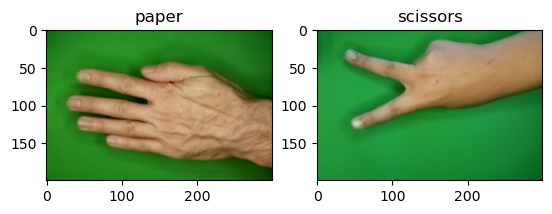

In [5]:
label_str = sorted(os.listdir(dataset_directory))  # automatic label list

image_5th = images[4]
label_5th = label_str[labels[4]]

image_last5th = images[-4]
label_last5th = label_str[labels[-4]]

plt.subplot(1, 2, 1)
plt.title(label_5th)
plt.imshow(image_5th)

plt.subplot(1, 2, 2)
plt.title(label_last5th)
plt.imshow(image_last5th)
plt.show()


In [6]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.3)
y_train = np.array(y_train)
y_test = np.array(y_test)


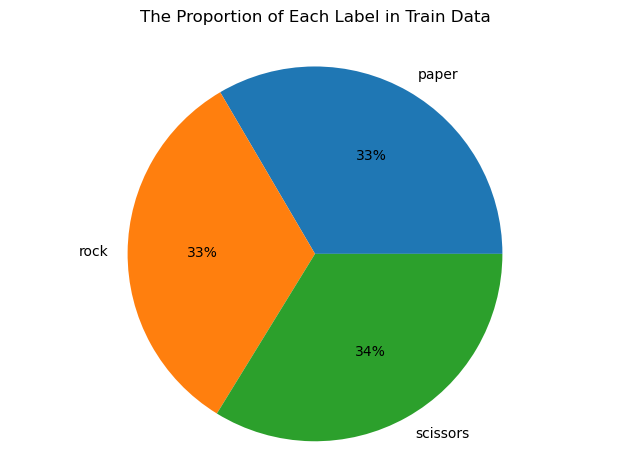

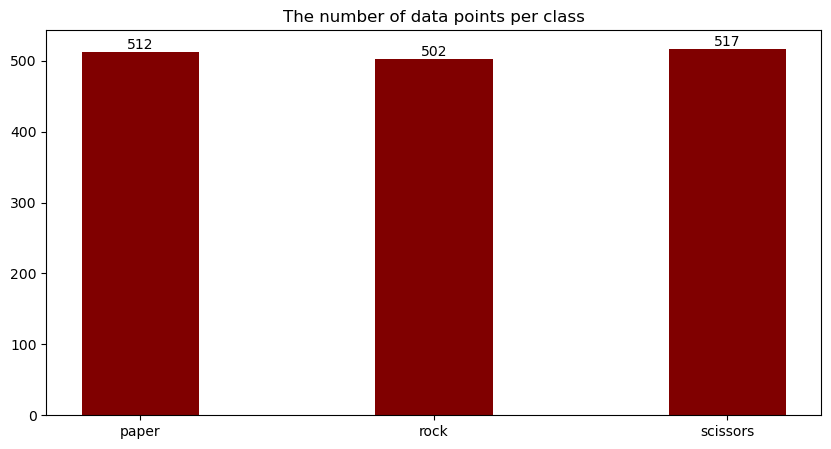

In [7]:
def Data_statistics(data_y, classes):
    counts = []
    for i in range(len(classes)):
        counts.append(np.sum(data_y == i))

    fig1, ax1 = plt.subplots()
    ax1.pie(counts, labels=classes, autopct='%0.0f%%')
    ax1.axis('equal')
    plt.title("The Proportion of Each Label in Train Data\n")
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(10, 5))
    bars = plt.bar(classes, counts, color='maroon', width=0.4)
    plt.title("The number of data points per class")

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

    plt.show()

Data_statistics(y_train, label_str)


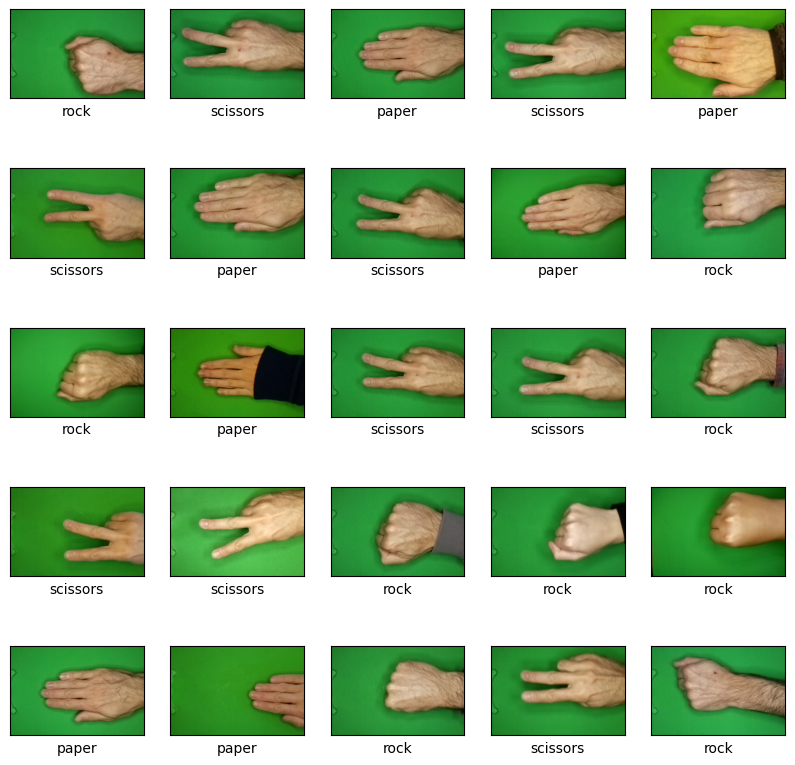

In [8]:
def Data_visualization(data_x, data_y, classes, grid_size):
    num_images = len(data_x)
    num_subplots = min(grid_size[0] * grid_size[1], num_images)

    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 10))
    axes = axes.flatten()

    for i in range(num_subplots):
        ax = axes[i]
        ax.imshow(data_x[i])
        ax.set(xticks=[], yticks=[], xlabel=classes[data_y[i]])

    for j in range(num_subplots, len(axes)):
        axes[j].axis('off')

    plt.show()

Data_visualization(x_train, y_train, label_str, grid_size=(5, 5))


In [9]:
def Data_Preprocessing(x_train, y_train, x_test, y_test, Batch_size):
    train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=20,
        rescale=1./255
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow(x_train, y_train, batch_size=Batch_size)
    test_generator = test_datagen.flow(x_test, y_test, batch_size=Batch_size, shuffle=False)

    return train_generator, test_generator

BATCH_SIZE = 64
train_gen, test_gen = Data_Preprocessing(x_train, y_train, x_test, y_test, Batch_size=BATCH_SIZE)


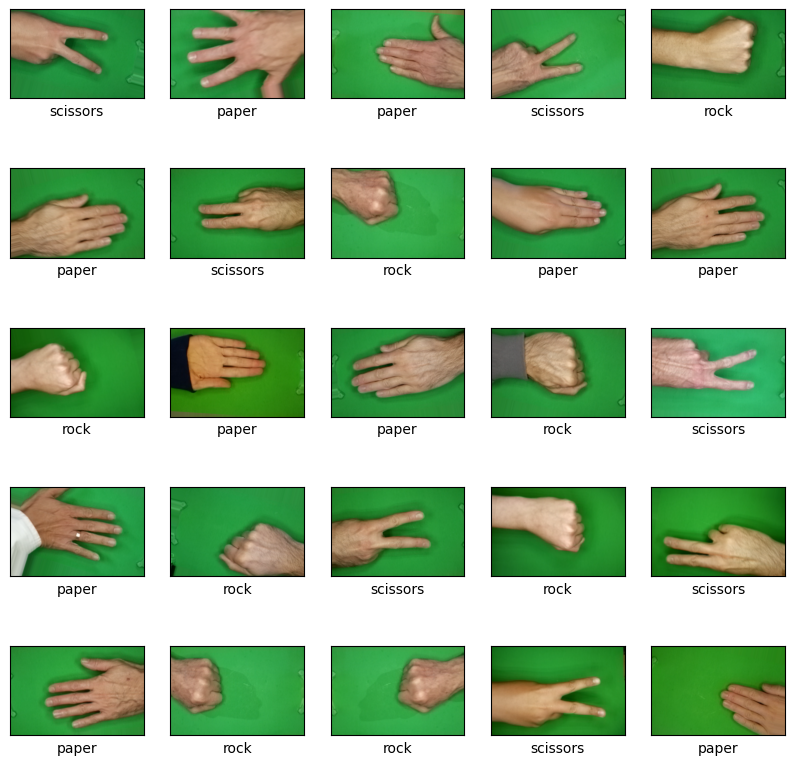

In [10]:
NUM_BATCHES_TO_DISPLAY = 1
displayed_batches = 0

for batch in train_gen:
    images, labels = batch
    Data_visualization(images, labels, label_str, grid_size=(5, 5))
    displayed_batches += 1
    if displayed_batches >= NUM_BATCHES_TO_DISPLAY:
        break


In [11]:
def CaptureImage(cameraPort, VideoResolution, input_size):
    image_count = 0
    cam = cv2.VideoCapture(cameraPort)
    print("Space ==> Capture, Esc => Q")

    while True:
        ret, frame = cam.read()
        frame = frame[
            int(frame.shape[0]/2 - VideoResolution[0]/2):int(frame.shape[0]/2 + VideoResolution[0]/2),
            int(frame.shape[1]/2 - VideoResolution[1]/2):int(frame.shape[1]/2 + VideoResolution[1]/2), :
        ]
        frame_t = cv2.resize(frame, input_size)
        frame_t = np.array(frame_t)

        cv2.imshow('Image', frame_t)
        if not ret:
            print("Failed. Try Again!")
            break

        if cv2.waitKey(1) & 0xFF == ord(' '):  # Space to capture
            print("Image captured!")
            label = input("Enter label for the image (rock, paper, or scissors): ").lower()
            while label not in ["rock", "paper", "scissors"]:
                label = input("Enter label for the image (rock, paper, or scissors): ").lower()

            # Save image inside the correct folder
            cv2.imwrite(f'{label}/captured_image_{image_count:05d}.png', frame_t)
            image_count += 1

        if cv2.waitKey(1) & 0xFF == ord('q'):  # Q to quit
            break

    cam.release()
    cv2.destroyAllWindows()


In [12]:
dataset_directory = 'rps-cv-images'  # correct path
image_size = (300, 200)


In [13]:
def load_data(train_dir, size):
    print("Data loading started ...\n")
    uniq_labels = sorted(os.listdir(train_dir))  # e.g., ['paper', 'rock', 'scissors']

    images = []
    labels = []

    for idx, label in enumerate(uniq_labels):
        for image in os.listdir(os.path.join(train_dir, label)):
            temp_img = cv2.imread(os.path.join(train_dir, label, image))
            if temp_img is None:
                continue
            temp_img = cv2.resize(temp_img, (size[0], size[1]))
            temp_img_rgb = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
            images.append(temp_img_rgb)
            labels.append(idx)

    images = np.array(images)
    print("Data loading completed ...\n")
    return images, labels


In [14]:
images, labels = load_data(dataset_directory, image_size)

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.3)
y_train = np.array(y_train)
y_test = np.array(y_test)

label_str = sorted(os.listdir(dataset_directory))  # ['paper', 'rock', 'scissors']


Data loading started ...

Data loading completed ...



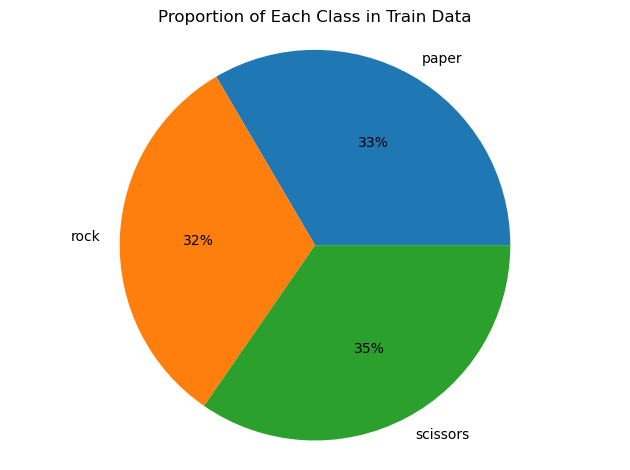

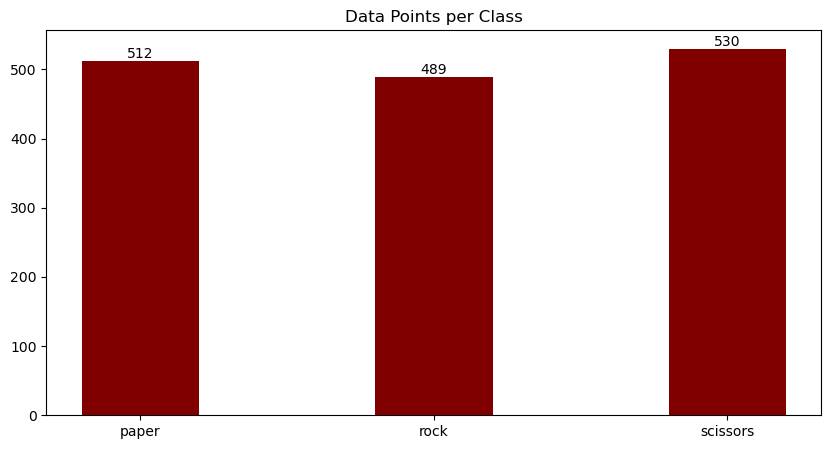

In [15]:
def Data_statistics(data_y, classes):
    counts = [np.sum(data_y == i) for i in range(len(classes))]

    fig1, ax1 = plt.subplots()
    ax1.pie(counts, labels=classes, autopct='%0.0f%%')
    ax1.axis('equal')
    plt.title("Proportion of Each Class in Train Data")
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(10, 5))
    bars = plt.bar(classes, counts, color='maroon', width=0.4)
    plt.title("Data Points per Class")

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

    plt.show()

Data_statistics(y_train, label_str)


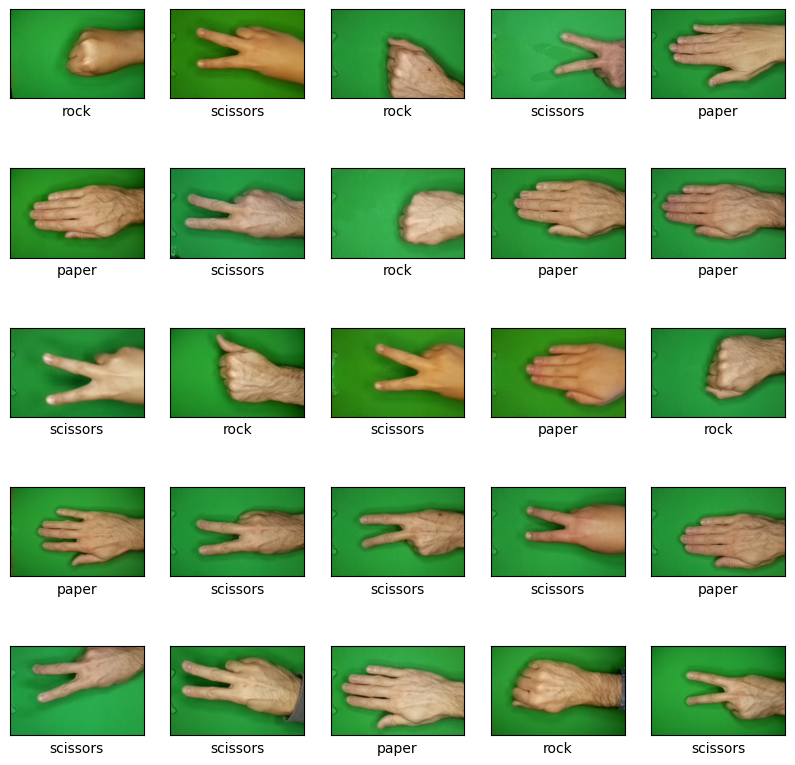

In [16]:
def Data_visualization(data_x, data_y, classes, grid_size):
    num_images = len(data_x)
    num_subplots = min(grid_size[0] * grid_size[1], num_images)

    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 10))
    axes = axes.flatten()

    for i in range(num_subplots):
        ax = axes[i]
        ax.imshow(data_x[i])
        ax.set(xticks=[], yticks=[], xlabel=classes[data_y[i]])

    for j in range(num_subplots, len(axes)):
        axes[j].axis('off')

    plt.show()

Data_visualization(x_train, y_train, label_str, grid_size=(5, 5))


In [17]:
def Data_Preprocessing(x_train, y_train, x_test, y_test, Batch_size):
    train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=20,
        rescale=1./255
    )
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow(x_train, y_train, batch_size=Batch_size)
    test_generator = test_datagen.flow(x_test, y_test, batch_size=Batch_size, shuffle=False)

    return train_generator, test_generator

BATCH_SIZE = 64
train_gen, test_gen = Data_Preprocessing(x_train, y_train, x_test, y_test, Batch_size=BATCH_SIZE)


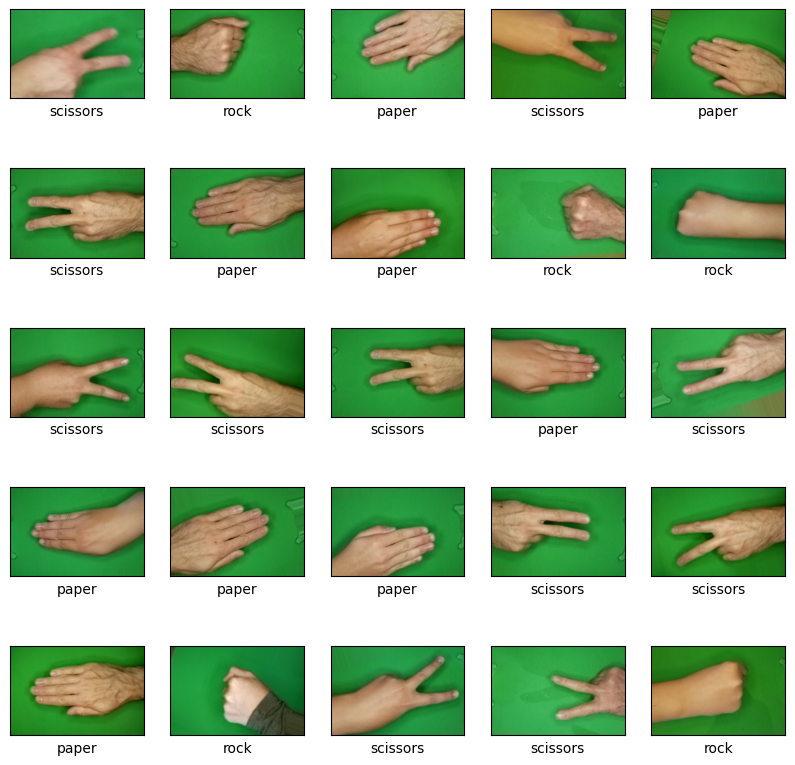

In [18]:
NUM_BATCHES_TO_DISPLAY = 1
displayed_batches = 0

for batch in train_gen:
    images, labels = batch
    Data_visualization(images, labels, label_str, grid_size=(5, 5))
    displayed_batches += 1
    if displayed_batches >= NUM_BATCHES_TO_DISPLAY:
        break


In [19]:
import os
import numpy as np
import cv2
from time import time
from tensorflow.keras import utils
from tensorflow.keras import datasets, layers, models, optimizers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

In [20]:
def one_hot_encoding(labels):
    # Get the number of samples and unique labels
    num_samples = len(labels)
    num_unique_labels = len(np.unique(labels))

    # Initialize the one-hot encoded array with zeros
    label_encoding = np.zeros((num_samples, num_unique_labels))

    # Iterate over each label and set the corresponding index to 1
    for i, label in enumerate(labels):
        label_encoding[i, label] = 1.
    return label_encoding


def load_data(train_dir, size):
    print("Data loading started ...\n")
    # Sort directories inside the dataset directory alphabetically.
    uniq_labels = sorted(os.listdir(train_dir))

    # Data containers
    images = []
    labels = []
    labels_str = []

    # Iterate over each label folder.
    for idx, label in enumerate(uniq_labels):
        # Iterate over each image inside the folder
        for image in os.listdir(train_dir + '/' + label):
            # Read the image using opencv.
            temp_img = cv2.imread(train_dir + '/' + label + '/' + image)
            # Skip in case image data is None
            if temp_img is None:
                continue
            # Resize the image into predefined dimensions.
            temp_img = cv2.resize(temp_img, (size[0], size[1]))
            # Add the image to image container.
            images.append(temp_img)
            # Add an appending label's index into the label container.
            labels.append(idx)
            labels_str.append(label)

    # Convert the list into numpy array.
    images = np.array(images)
    labels = np.array(labels)
    print("Data loading completed ...\n")
    # Return images, labels, and unique labels
    return images, labels, set(labels_str)


def Data_Preprocessing(x_train, y_train, x_val, y_val, x_test, y_test, Batch_size):
    # Training generator (Data Augmentation)
    train_datagen = ImageDataGenerator(
        horizontal_flip=True,    # Horizontal flip
        vertical_flip=True,      # Vertical flip
        rotation_range=20,       # Rotation 20 degrees (left or right)
        rescale=1./255)          # Normalization of the pixels

    # Apply the transformation on the training dataset
    train_generator = train_datagen.flow(x_train, y_train, batch_size=Batch_size)

    # Validation generator for testing data. Since testing data is just for evaluating the performance
    # test, there is no need to apply data augmentation on the data.
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Apply the transformation on the testing dataset
    test_generator = test_datagen.flow(x_test, y_test, batch_size=Batch_size, shuffle=False)
    val_generator = test_datagen.flow(x_val, y_val, batch_size=Batch_size, shuffle=False)

    return train_generator, val_generator, test_generator

In [21]:
# Step 1: Call load_data([directory], [image_resizing_shape]) and store the values in images and labels variables
dataset_directory = "rps-cv-images"
image_size = (300, 200)
images, labels, labels_str = load_data(dataset_directory, image_size)

# Step 2: Split the data into 70% training and 20% validation 10% testing using train_test_split() function.
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, stratify=labels)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.1, stratify=y_test)  # Here stratify

# Step 3: Use one_hot_encoding function to transform the labels of the training and testing from normal shape to one-hot-encoding shape.
y_train_encoded = one_hot_encoding(y_train)
y_test_encoded = one_hot_encoding(y_test)
y_val_encoded = one_hot_encoding(y_val)

y_train = np.array(y_train)
y_test = np.array(y_test)

# Step 4: Use Data_Preprocessing() function to preprocessing the training and testing data.
BATCH_SIZE = 64
train_gen, val_gen, test_gen = Data_Preprocessing(x_train, y_train_encoded, x_val, y_val_encoded, x_test, y_test_encoded, Batch_size=BATCH_SIZE)

Data loading started ...

Data loading completed ...



In [22]:
# Reshape arrays
y_train_flatten = y_train.flatten()
y_test_flatten = y_test.flatten()

# Create target vectors y_train_rock and y_test_rock
# For this classification task to make it true if the y is equal to 'rock' encoded as 1
y_train_rock = (y_train_flatten == 1)
y_test_rock = (y_test_flatten == 1)

In [23]:
from sklearn.linear_model import SGDClassifier

# Initialize SGDClassifier
binary_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

In [24]:
# Flatten the images if they are not flattened
# Example: From (n_samples, 300, 200, 3) to (n_samples, 180000)
n_samples, nx, ny, nz = x_train.shape
x_train_flat = x_train.reshape((n_samples, nx * ny * nz))

n_samples_test, nx_test, ny_test, nz_test = x_test.shape
x_test_flat = x_test.reshape((n_samples_test, nx_test * ny_test * nz_test))

In [25]:
from sklearn.preprocessing import StandardScaler

# Create an instance of StandardScaler
scaler = StandardScaler()

# Scale the pixel values (important for SGDClassifier)
x_train_scaled = scaler.fit_transform(x_train_flat.astype(np.float64))
x_test_scaled = scaler.transform(x_test_flat.astype(np.float64))

In [26]:
# Train the classifier
binary_clf.fit(x_train_scaled, y_train_rock)

SGDClassifier(random_state=42)

Accuracy: 0.9090909090909091
              precision    recall  f1-score   support

    Not Rock       0.95      0.91      0.93        44
        Rock       0.83      0.91      0.87        22

    accuracy                           0.91        66
   macro avg       0.89      0.91      0.90        66
weighted avg       0.91      0.91      0.91        66



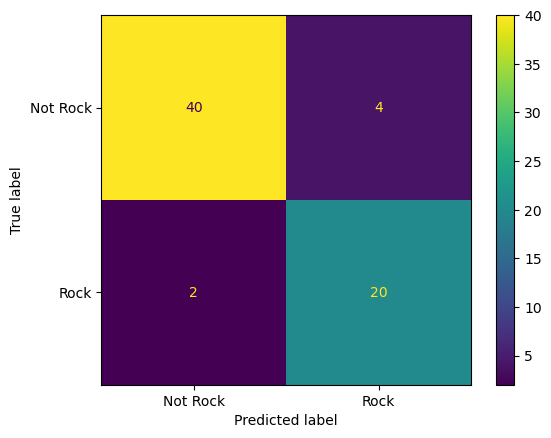

In [27]:
# Predict the labels for the test set
y_pred = binary_clf.predict(x_test_scaled)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test_rock, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print(classification_report(y_test_rock, y_pred, target_names=['Not Rock', 'Rock']))

# Generate and display a confusion matrix
cm1 = confusion_matrix(y_test_rock, y_pred)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=['Not Rock', 'Rock'])
disp1.plot()
plt.show()

In [28]:
multi_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

# Train the classifier
multi_clf.fit(x_train_scaled, y_train)

SGDClassifier(random_state=42)

Accuracy: 0.8787878787878788
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        21
           1       0.89      0.77      0.83        22
           2       0.88      1.00      0.94        23

    accuracy                           0.88        66
   macro avg       0.88      0.88      0.88        66
weighted avg       0.88      0.88      0.88        66



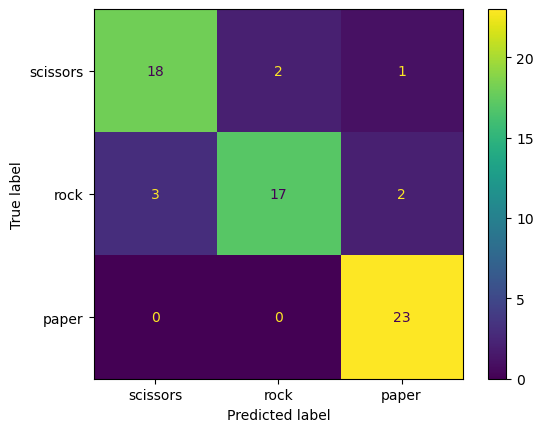

In [29]:
# Making predictions
y_pred2 = multi_clf.predict(x_test_scaled)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred2)
print(f"Accuracy: {accuracy}")

# More detailed report
print(classification_report(y_test, y_pred2))

# Confusion Matrix
cm2 = confusion_matrix(y_test, y_pred2, labels=range(len(labels_str)))
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=labels_str)
disp2.plot()
plt.show()

In [30]:
ANN = models.Sequential()

# Input Layer
ANN.add(Flatten(input_shape=[300, 200, 3]))

# Hidden Layers followed by batch normalization and relu function
ANN.add(Dense(256))
ANN.add(BatchNormalization())
ANN.add(Activation('relu'))

ANN.add(Dense(128))
ANN.add(BatchNormalization())
ANN.add(Activation('relu'))

# Output Layer
ANN.add(Dense(3, activation='softmax'))

ANN.summary()

ANN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
ANN_history = ANN.fit(train_gen, epochs=40, validation_data=val_gen)

C:\Users\Marwan\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 180000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    46,080,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,115,075 (175.92 MB)

 Trainable params: 46,114,307 (175.91 MB)

 Non-trainable params: 768 (3.00 KB)

C:\Users\Marwan\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5438 - loss: 1.1394 - val_accuracy: 0.5381 - val_loss: 1.3612
Epoch 2/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 912ms/step - accuracy: 0.7520 - loss: 0.6360 - val_accuracy: 0.3723 - val_loss: 2.0539
Epoch 3/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 901ms/step - accuracy: 0.7961 - loss: 0.5425 - val_accuracy: 0.7174 - val_loss: 0.7049
Epoch 4/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 903ms/step - accuracy: 0.8490 - loss: 0.4124 - val_accuracy: 0.6971 - val_loss: 0.8065
Epoch 5/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 912ms/step - accuracy: 0.8957 - loss: 0.3111 - val_accuracy: 0.8342 - val_loss: 0.4629
Epoch 6/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 925ms/step - accuracy: 0.9176 - loss: 0.2723 - val_accuracy: 0.6379 - val_loss: 1.0722
Epoch 7/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 898ms/step - accuracy: 0.9234 - loss: 0.2479 - val_accuracy: 0.9002 - val_loss: 0.3167
Epoch 8/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 918ms/step - accuracy: 0.9119 - loss: 0.2391 - val_accurac

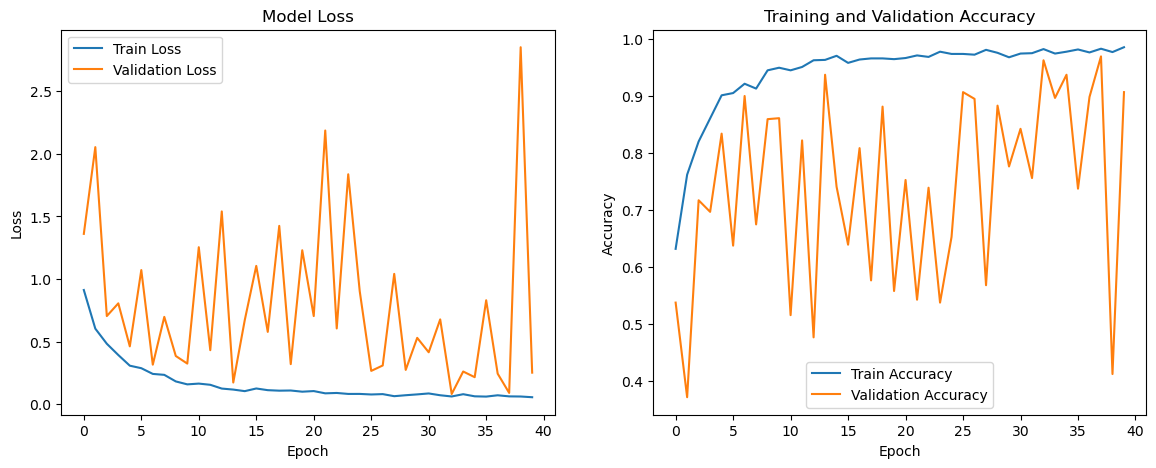

In [31]:
# Define the size of the overall figure
plt.figure(figsize=(14, 5))

# First subplot for loss
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.plot(ANN_history.history['loss'], label='Train Loss')
plt.plot(ANN_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Second subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(ANN_history.history['accuracy'], label='Train Accuracy')
plt.plot(ANN_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Show the plot
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Prediction probabilities: [[9.2036682e-01 3.3016308e-04 7.9303063e-02]
 [4.3192083e-01 1.4985015e-02 5.5309421e-01]
 [8.6672464e-04 9.9844450e-01 6.8878895e-04]
 [4.4897655e-01 9.9504970e-02 4.5151848e-01]
 [2.7000342e-02 1.6095720e-01 8.1204236e-01]
 [1.2364224e-02 9.8761290e-01 2.2954486e-05]
 [4.7454763e-05 1.3998433e-04 9.9981266e-01]
 [2.9363128e-04 1.9406927e-05 9.9968696e-01]
 [7.2357355e-04 9.9421751e-01 5.0588567e-03]
 [8.8823522e-03 9.3867940e-01 5.2438188e-02]
 [5.6207391e-06 5.0676605e-05 9.9994373e-01]
 [2.9955967e-03 9.9684960e-01 1.5484172e-04]
 [3.4184170e-05 2.5674762e-04 9.9970907e-01]
 [1.1142757e-03 9.9583960e-01 3.0461357e-03]
 [9.9951100e-01 1.8268251e-05 4.7080667e-04]
 [7.0059177e-05 9.9942172e-01 5.0822459e-04]
 [9.4461051e-05 1.5479302e-04 9.9975067e-01]
 [9.0827270e-05 9.3274350e-05 9.9981588e-01]
 [1.4857556e-05 3.4167537e-05 9.9995089e-01]
 [4.1772737e-03 9.9427444e-01 1.5483310e-03]
 [7.3571659e-06 9.9951935e-01 4.7335

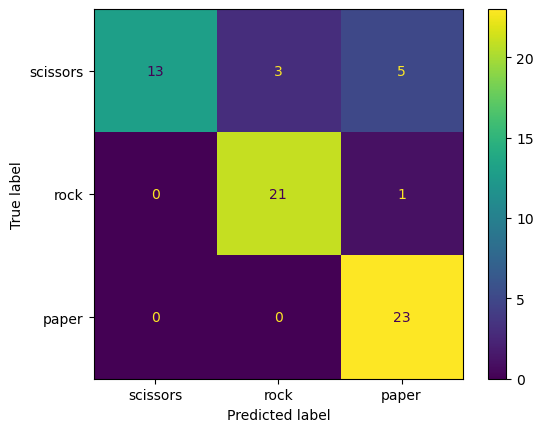

In [32]:
predictions = ANN.predict(test_gen)
print("Prediction probabilities:", predictions)

y_pred3 = np.argmax(predictions, axis=1)
print()
print(classification_report(y_test, y_pred3, target_names=labels_str))

# Confusion Matrix
cm3 = confusion_matrix(y_test, y_pred3, labels=range(len(labels_str)))
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=labels_str)
disp3.plot()
plt.show()

In [33]:
# Step 1: Model architecture
CNN1 = models.Sequential()

# First layer, an input layer
# 2D convolutional layer with 16 nodes, 3x3 filter
CNN1.add(Conv2D(16, (3, 3), input_shape=(300, 200, 3)))
CNN1.add(BatchNormalization())
CNN1.add(Activation('relu'))
# 2D max-pooling layer with a size 2x2
CNN1.add(MaxPooling2D(pool_size=(2, 2)))

# Second layer
CNN1.add(Conv2D(32, (3, 3)))
CNN1.add(BatchNormalization())
CNN1.add(Activation('relu'))
CNN1.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and dense layers
CNN1.add(Flatten())
CNN1.add(Dense(100))
CNN1.add(BatchNormalization())
CNN1.add(Activation('relu'))
CNN1.add(Dense(3, activation='softmax'))

# Step 2: Display the model architecture
CNN1.summary()

# Step 3: Compile the model
CNN1.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

# Step 4: Train the model using .fit()
history1 = CNN1.fit(train_gen,
                    epochs=10,
                    validation_data=val_gen)


C:\Users\Marwan\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 298, 198, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 298, 198, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 298, 198, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 99, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 97, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 147, 97, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 147, 97, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 112128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │    11,212,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,218,883 (42.80 MB)

 Trainable params: 11,218,587 (42.80 MB)

 Non-trainable params: 296 (1.16 KB)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5855 - loss: 1.0659 - val_accuracy: 0.5025 - val_loss: 1.5476
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8611 - loss: 0.4221 - val_accuracy: 0.3553 - val_loss: 1.9969
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9090 - loss: 0.2765 - val_accuracy: 0.3486 - val_loss: 2.5000
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9399 - loss: 0.2017 - val_accuracy: 0.4839 - val_loss: 2.5437
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9358 - loss: 0.1848 - val_accuracy: 0.4044 - val_loss: 2.7786
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9624 - loss: 0.1191 - val_accuracy: 0.3452 - val_loss: 3.8039
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9683 - loss: 0.0999 - val_accuracy: 0.3604 - val_loss: 3.6185
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9703 - loss: 0.0977 - val_accuracy: 0.3486 - val_loss:

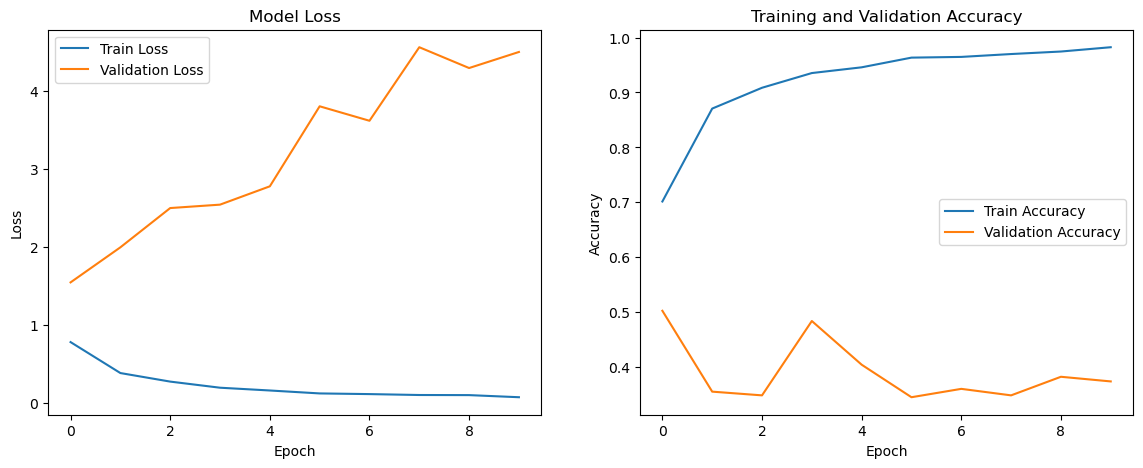

In [34]:
# Define the size of the overall figure
plt.figure(figsize=(14, 5))

# First subplot for loss
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Second subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Show the plot
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Prediction probabilities: [[2.85337023e-06 1.67929560e-01 8.32067549e-01]
 [1.45516742e-06 2.44965702e-02 9.75501895e-01]
 [1.03749915e-06 7.11473674e-02 9.28851664e-01]
 [2.25200392e-06 6.10911287e-02 9.38906670e-01]
 [8.91176796e-07 8.57323855e-02 9.14266765e-01]
 [3.82407006e-06 5.59946120e-01 4.40050066e-01]
 [6.56663531e-07 7.86663890e-02 9.21333015e-01]
 [1.73527189e-06 4.61268276e-02 9.53871489e-01]
 [3.38103405e-06 6.20863810e-02 9.37910199e-01]
 [1.35880566e-06 1.95585117e-01 8.04413557e-01]
 [2.03824612e-07 4.70654182e-02 9.52934384e-01]
 [1.23550763e-06 5.17467856e-02 9.48252022e-01]
 [5.20266724e-07 7.03095719e-02 9.29689825e-01]
 [4.93942616e-06 1.06942199e-01 8.93052936e-01]
 [9.44537023e-05 5.34047842e-01 4.65857655e-01]
 [1.45769525e-06 2.14707732e-01 7.85290778e-01]
 [3.30392709e-07 2.46267617e-02 9.75372910e-01]
 [7.26212193e-07 9.10105035e-02 9.08988714e-01]
 [3.35374722e-07 2.57484522e-02 9.74251211e-01]
 [9.92274977e-07 1.89875

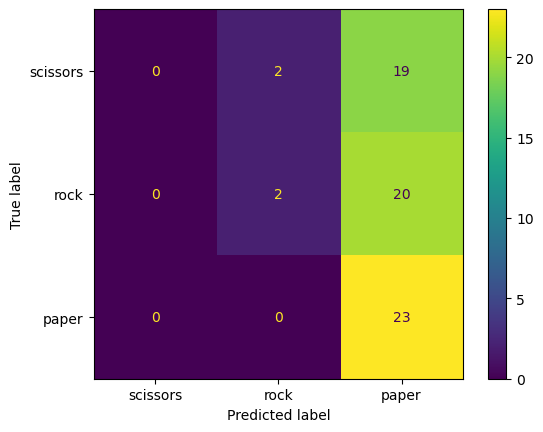

In [35]:
predictions = CNN1.predict(test_gen)
print("Prediction probabilities:", predictions)

y_pred4 = np.argmax(predictions, axis=1)

print(classification_report(y_test, y_pred4, target_names=labels_str, zero_division=1))

# Confusion Matrix
cm4 = confusion_matrix(y_test, y_pred4, labels=range(len(labels_str)))
disp4 = ConfusionMatrixDisplay(confusion_matrix=cm4, display_labels=labels_str)
disp4.plot()

In [36]:
# Step 1: Model architecture
CNN2 = models.Sequential()

# First layer, an input layer
# 2D convolutional layer with 16 nodes, 3x3 filter
CNN2.add(Conv2D(16, (3, 3), input_shape=(300, 200, 3)))
CNN2.add(BatchNormalization())
CNN2.add(Activation('relu'))
# 2D max-pooling layer with a size 2x2
CNN2.add(MaxPooling2D(pool_size=(2, 2)))

# Second Layer
CNN2.add(Conv2D(32, (3, 3)))
CNN2.add(BatchNormalization())
CNN2.add(Activation('relu'))
CNN2.add(MaxPooling2D(pool_size=(2, 2)))

# Third layer
CNN2.add(Conv2D(64, (3, 3)))
CNN2.add(BatchNormalization())
CNN2.add(Activation('relu'))
CNN2.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and dense layers
CNN2.add(Flatten())
CNN2.add(Dense(200))
CNN2.add(BatchNormalization())
CNN2.add(Activation('relu'))

CNN2.add(Dense(3, activation='softmax'))

# Step 2: Display the model architecture
CNN2.summary()

# Step 3: Compile the model
CNN2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

# Step 4: Train the model using .fit()
history2 = CNN2.fit(train_gen,
                    epochs=20,
                    validation_data=val_gen)

C:\Users\Marwan\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 298, 198, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 298, 198, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 298, 198, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 149, 99, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 147, 97, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 147, 97, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 147, 97, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 73, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 71, 46, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 71, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 71, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 35, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 51520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │    10,304,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           603 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,329,635 (39.40 MB)

 Trainable params: 10,329,011 (39.40 MB)

 Non-trainable params: 624 (2.44 KB)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6057 - loss: 1.3974 - val_accuracy: 0.5347 - val_loss: 2.0898
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9113 - loss: 0.2558 - val_accuracy: 0.3503 - val_loss: 2.7124
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9479 - loss: 0.1677 - val_accuracy: 0.3316 - val_loss: 3.2904
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9580 - loss: 0.1161 - val_accuracy: 0.3316 - val_loss: 3.6023
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9811 - loss: 0.0779 - val_accuracy: 0.3587 - val_loss: 3.7290
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9749 - loss: 0.0813 - val_accuracy: 0.3350 - val_loss: 4.0055
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9829 - loss: 0.0665 - val_accuracy: 0.3316 - val_loss: 4.1848
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9812 - loss: 0.0606 - val_accuracy: 0.4670 - val_loss:

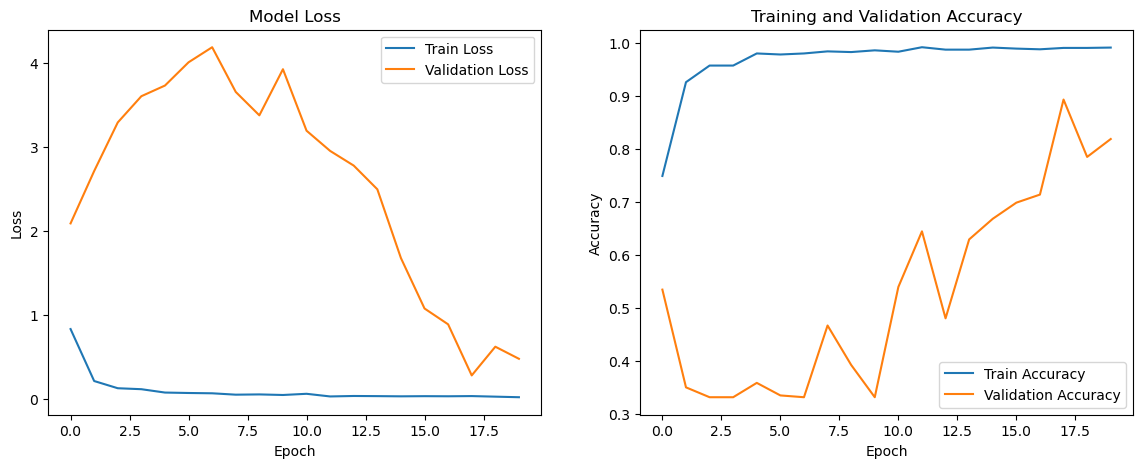

In [37]:
# Define the size of the overall figure
plt.figure(figsize=(14, 5))

# First subplot for loss
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Second subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Show the plot
plt.show()

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000023ECF479D00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Prediction probabilities: [[3.8130727e-02 9.5753020e-01 4.3390724e-03]
 [4.4790870e-01 8.2187178e-03 5.4387259e-01]
 [8.7311477e-05 9.9942857e-01 4.8408014e-04]
 [1.8629251e-01 7.9205531e-01 2.1652

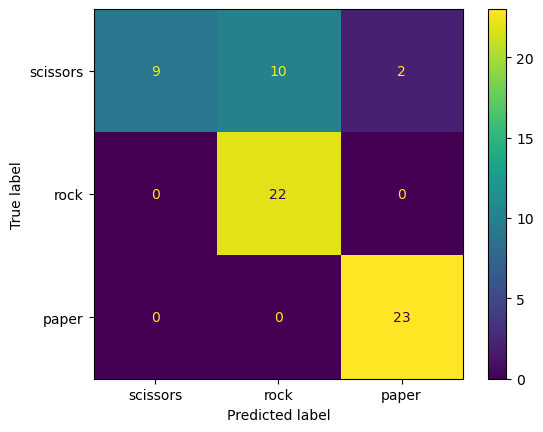

In [38]:
predictions = CNN2.predict(test_gen)
print("Prediction probabilities:", predictions)

y_pred5 = np.argmax(predictions, axis=1)

print(classification_report(y_test, y_pred5, target_names=labels_str))

# Confusion Matrix
cm5 = confusion_matrix(y_test, y_pred5, labels=range(len(labels_str)))
disp5 = ConfusionMatrixDisplay(confusion_matrix=cm5, display_labels=labels_str)
disp5.plot()

In [39]:
# Step 1: Model architecture
CNN = models.Sequential()

# First layer, an input layer
# 2D convolutional layer with 32 nodes, 3x3 filter
CNN.add(Conv2D(32, (3, 3), input_shape=(300, 200, 3)))
CNN.add(BatchNormalization())
CNN.add(Activation('relu'))
# 2D max-pooling layer with a size 2x2
CNN.add(MaxPooling2D(pool_size=(2, 2)))
CNN.add(Dropout(0.25))  # dropout layer to reduce overfitting

# Second Layer
CNN.add(Conv2D(64, (3, 3)))
CNN.add(BatchNormalization())
CNN.add(Activation('relu'))
CNN.add(MaxPooling2D(pool_size=(2, 2)))
CNN.add(Dropout(0.25))  # dropout layer to reduce overfitting

# Third Layer
CNN.add(Conv2D(128, (3, 3)))
CNN.add(BatchNormalization())
CNN.add(Activation('relu'))
CNN.add(MaxPooling2D(pool_size=(2, 2)))
CNN.add(Dropout(0.25))  # dropout layer to reduce overfitting

# Fourth Layer
CNN.add(Conv2D(256, (3, 3)))
CNN.add(BatchNormalization())
CNN.add(Activation('relu'))
CNN.add(MaxPooling2D(pool_size=(2, 2)))
CNN.add(Dropout(0.25))  # dropout layer to reduce overfitting

# Flatten and dense layers
CNN.add(Flatten())
CNN.add(Dense(512))
CNN.add(BatchNormalization())
CNN.add(Activation('relu'))
CNN.add(Dropout(0.5))  # dropout layer to reduce overfitting

CNN.add(Dense(3, activation='softmax'))

# Step 2: Display the model architecture
CNN.summary()

# Step 3: Compile the model
CNN.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

# Step 4: Train the model using .fit()
history = CNN.fit(train_gen,
                  epochs=55,
                  validation_data=val_gen)

C:\Users\Marwan\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 298, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 298, 198, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 298, 198, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 149, 99, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 149, 99, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 147, 97, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 147, 97, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 147, 97, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 73, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 73, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 71, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 71, 46, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 71, 46, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 35, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 35, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 33, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 33, 21, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 33, 21, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │    20,972,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,04

 Total params: 21,365,955 (81.50 MB)

 Trainable params: 21,363,971 (81.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.6004 - loss: 1.4721 - val_accuracy: 0.3316 - val_loss: 1.7212
Epoch 2/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.8206 - loss: 0.5139 - val_accuracy: 0.3316 - val_loss: 2.1234
Epoch 3/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.9178 - loss: 0.2227 - val_accuracy: 0.3418 - val_loss: 2.3603
Epoch 4/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.9419 - loss: 0.1762 - val_accuracy: 0.3418 - val_loss: 2.8909
Epoch 5/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.9624 - loss: 0.1204 - val_accuracy: 0.3418 - val_loss: 3.2719
Epoch 6/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.9732 - loss: 0.0792 - val_accuracy: 0.3418 - val_loss: 3.7003
Epoch 7/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.9796 - loss: 0.0719 - val_accuracy: 0.3418 - val_loss: 3.5100
Epoch 8/55
24/24 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.9795 - loss: 0.0694 - val_accuracy: 0.3418 - val_loss

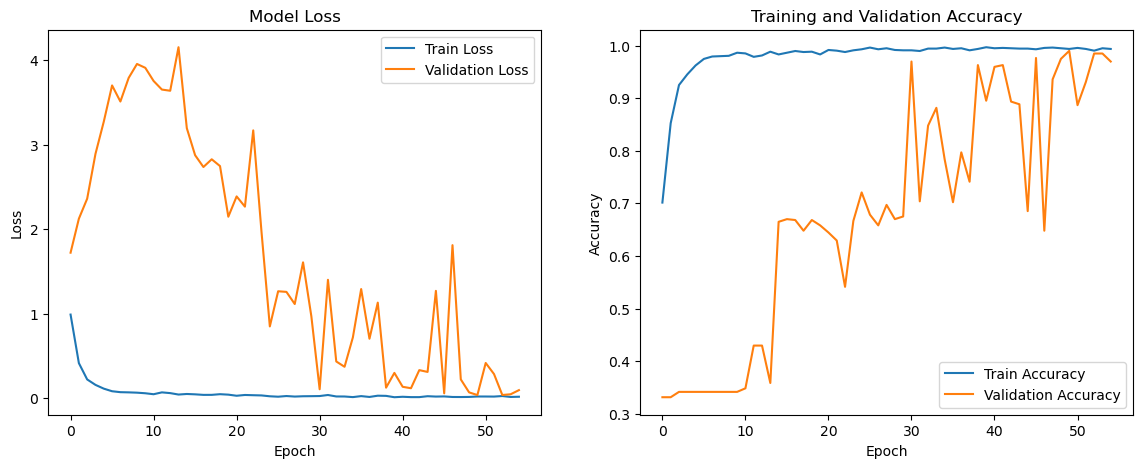

In [40]:
# Define the size of the overall figure
plt.figure(figsize=(14, 5))

# First subplot for loss
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Second subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Show the plot
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step
Prediction probabilities: [[9.92736995e-01 7.04800291e-03 2.15078544e-04]
 [9.98764753e-01 2.99689691e-05 1.20532338e-03]
 [6.87764896e-07 9.99996662e-01 2.65367589e-06]
 [9.99393225e-01 6.02308137e-04 4.39380801e-06]
 [1.85600550e-06 6.61178085e-04 9.99336898e-01]
 [1.60550954e-07 9.99999642e-01 1.53467113e-07]
 [1.41219598e-05 5.71870692e-02 9.42798793e-01]
 [1.63592471e-04 8.07057768e-02 9.19130683e-01]
 [2.31918730e-05 9.99973655e-01 3.19700189e-06]
 [1.41245226e-04 9.99693155e-01 1.65612189e-04]
 [1.05879829e-08 1.62555511e-06 9.99998331e-01]
 [2.40748227e-06 9.99996781e-01 7.96815982e-07]
 [2.65133650e-07 1.75017176e-05 9.99982238e-01]
 [1.89976621e-04 9.99799430e-01 1.05590543e-05]
 [8.13556910e-01 1.86424255e-01 1.88392423e-05]
 [6.00640624e-06 9.99989629e-01 4.39981113e-06]
 [1.26700328e-07 1.03373932e-05 9.99989510e-01]
 [1.37278789e-06 1.07554129e-04 9.99891043e-01]
 [2.77298994e-07 4.80397604e-04 9.99519348e-01]
 [2.37007225e-06 9.9999

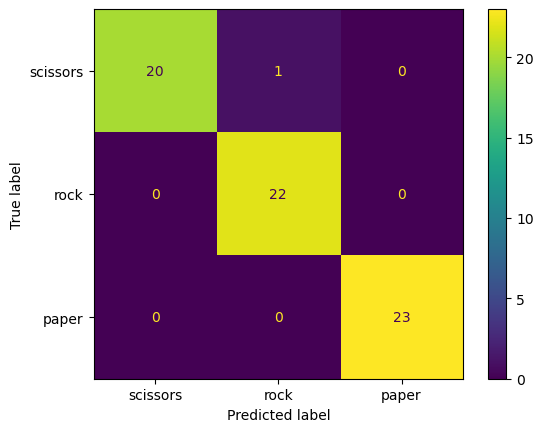

In [41]:
predictions = CNN.predict(test_gen)
print("Prediction probabilities:", predictions)

y_pred6 = np.argmax(predictions, axis=1)

print(classification_report(y_test, y_pred6, target_names=labels_str))

# Confusion Matrix
cm6 = confusion_matrix(y_test, y_pred6, labels=range(len(labels_str)))
disp6 = ConfusionMatrixDisplay(confusion_matrix=cm6, display_labels=labels_str)
disp6.plot()

In [42]:
CNN.save("CNN_model_Team1.keras")

In [43]:
model1 = load_model("CNN_model_Team1.keras")

In [48]:
def preprocess_image(frame, input_size):
    frame_resized = cv2.resize(frame, (input_size[1], input_size[0]))  # Ensure dimensions are in the correct order
    frame_normalized = frame_resized / 255.0  # Normalize pixel values to [0, 1]
    return np.expand_dims(frame_normalized, axis=0)  # Add batch dimension

def predict_gesture(frame):
    processed_frame = preprocess_image(frame, (300, 200))
    prediction = model.predict(processed_frame)
    class_labels = ['paper', 'rock', 'scissors']
    #print("Prediction Softmax Output:", prediction[0])  # Print the softmax probabilities
    return class_labels[np.argmax(prediction)]

In [49]:
def evaluate_game(move1, move2):
    rules = {
        ('rock', 'scissors'): 'Player 1 wins!',
        ('scissors', 'rock'): 'Player 2 wins!',
        ('paper', 'rock'): 'Player 1 wins!',
        ('rock', 'paper'): 'Player 2 wins!',
        ('scissors', 'paper'): 'Player 1 wins!',
        ('paper', 'scissors'): 'Player 2 wins!',
        ('rock', 'rock'): 'Draw!',
        ('paper', 'paper'): 'Draw!',
        ('scissors', 'scissors'): 'Draw!'
    }
    return f"The result is: {rules[(move1, move2)]}"

In [51]:
def CaptureImage(cameraPort, VideoResolution, input_size):
    cam = cv2.VideoCapture(cameraPort)
    player_moves = []
    print("Space => Capture, Q => Quit")
    while len(player_moves) < 2:
        ret, frame = cam.read()
        if not ret:
            print("Failed to capture image. Try Again!")
            continue

        # Center crop the frame
        center_x, center_y = frame.shape[1] // 2, frame.shape[0] // 2
        frame_cropped = frame[center_y - VideoResolution[1]//2: center_y + VideoResolution[1]//2,
                              center_x - VideoResolution[0]//2: center_x + VideoResolution[0]//2]

        # Display the cropped frame
        cv2.imshow('Rock-Paper-Scissors', frame_cropped)
        key = cv2.waitKey(1) & 0xFF

        if key == ord(' '):  # Capture gesture on space bar press
            move = predict_gesture(frame_cropped)
            player_moves.append(move)
            print(f"Player {len(player_moves)} move: {move}")
            if len(player_moves) == 2:
                print(evaluate_game(player_moves[0], player_moves[1]))
                prءint()
                player_moves = []
        elif key == ord('q'):  # Quit on 'q' press
            break

    cam.release()
    cv2.destroyAllWindows()

CaptureImage(0, (300, 200), (300, 200))

Space => Capture, Q => Quit


NameError: name 'model' is not defined